# Mission 5 - Statistical Data Analysis

In [1198]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import beta
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from fractions import Fraction
from scipy.optimize import fmin

In [1199]:
print('Gili Yardeni {} and Ben Nadler {}'.format(205733918,308292309))

Gili Yardeni 205733918 and Ben Nadler 308292309


In [1200]:
musicData = pd.read_csv('dataset-of-10s.csv')

## Part 1 - Bayesian Approach

#### Section 1

In [1201]:
sampledData = musicData.sample(200, random_state=1)
priorData = pd.concat([musicData, sampledData]).drop_duplicates(keep=False).sample(1000, random_state=1)

Our variables are X=key and Y=mode

In [1202]:
X = sampledData['key']
Y = sampledData['mode']

#### Section 2

In [1203]:
tau = sampledData['key'].median()
sampledData['Z'] = [1 if tau < x else 0 for x in sampledData['key']]

In [1204]:
Xminor = sampledData[sampledData['mode'] == 0]
Xmajor = sampledData[sampledData['mode'] == 1]

for j=major,minor

In [1205]:
Pmajor = len(Xmajor[Xmajor['Z'] == 1]) / len(Xmajor)
Pminor = len(Xminor[Xminor['Z'] == 1]) / len(Xminor)
print(f'Pmajor={Pmajor} and Pminor={Pminor}')

Pmajor=0.4672131147540984 and Pminor=0.48717948717948717


#### Section 3.1

In [1206]:
odds_pmajor = (Pmajor / (1 - Pmajor))
odds_pminor = (Pminor / (1 - Pminor))
psi = np.log(odds_pmajor) - np.log(odds_pminor)
print(f'Our log of odds ratio psi={psi}')

Our log of odds ratio psi=-0.08004270767353652


In [1207]:
# for this mission we define B and alpha
B = 400
alpha = 0.05

In [1208]:
def bootstrap(data, B):
    psis = []
    for _ in range(B):
        samples = data.sample(200, replace=True)
        tau = samples['key'].median()
        samples['Z'] = [1 if tau < x else 0 for x in samples['key']]
        # seperate between calsses
        minor = samples[samples['mode'] == 0]
        major = samples[samples['mode'] == 1]
        # calculate pj
        Pmajor = len(major[major['Z'] == 1]) / len(major)
        Pminor = len(minor[minor['Z'] == 1]) / len(minor)
        # calculate odds
        odds_pmajor = (Pmajor / (1 - Pmajor))
        odds_pminor = (Pminor / (1 - Pminor))
        # log of odds ratio
        psi = np.log(odds_pmajor) - np.log(odds_pminor)
        psis.append(psi)
    return psis

In [1209]:
psis = bootstrap(sampledData, B)
def bootstrap_pencentile_ci(params, alpha):
    return [np.percentile(params, (alpha*100)/2), np.percentile(params, 100 - (alpha*100)/2)]

In [1210]:
print(bootstrap_pencentile_ci(psis, alpha))

[-0.8481026406096734, 0.37879040782636153]


#### Section 3.2

We assume uniform prior distribution $\pi(p_1, p_2) = 1I\{0\leq p_1,p_2 \leq1\}$<br>


We know that:<br>
$Z|Y=major\sim Bernoulli(p_1)$<br>
$Z|Y=minor\sim Bernoulli(p_2)$

$p1|Y=major \sim Beta(S_{major}+1,length(major)-S_{major}+1)$<br>
$p2|Y=minor \sim Beta(S_{minor}+1,length(minor)-S_{minor}+1)$

We can simmulate $(P_1^1,P_2^1),...,(P_1^B,P_2^B)$ from posteriors and estimate $\bar\psi$

In [1211]:
Smajor = len(Xmajor[Xmajor['Z'] == 1])
Sminor = len(Xminor[Xminor['Z'] == 1])
m = len(Xmajor)
n = len(Xminor)

In [1212]:
def simulate(Sma, Smi, m, n, const, hist=False):
    psis = []
    for _ in range(B):
        # sample pj from beta distribution
        Pmajor = np.random.beta(Sma+const, m-Sma+const,1)
        Pminor = np.random.beta(Smi+const, n-Smi+const,1)
        # calculate odds
        odds_pmajor = (Pmajor / (1 - Pmajor))
        odds_pminor = (Pminor / (1 - Pminor))
        # log of odds ratio
        psi = np.log(odds_pmajor) - np.log(odds_pminor)
        psis.append(psi)
    if hist:
        sns.distplot(psis, kde=True)    
        plt.title('Psi distribution')
    return psis

Based on simulations we find an estimator psi_bar=-0.06549289338680611


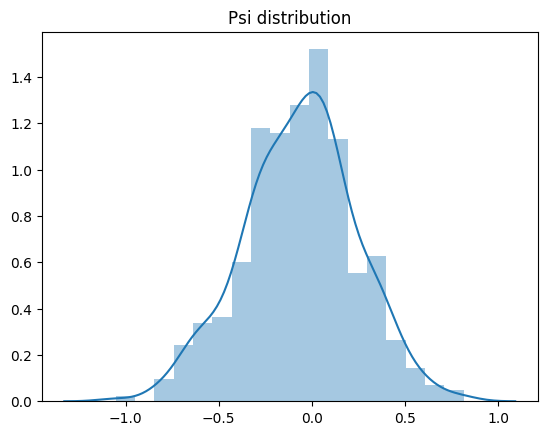

In [1213]:
psis = simulate(Smajor, Sminor, m, n, 1, True)
psi_bar = (1/B) * np.sum(psis)
print(f'Based on simulations we find an estimator psi_bar={psi_bar}')

In [1214]:
### credability interval
print(bootstrap_pencentile_ci(psis, alpha))

[-0.6641510696276685, 0.5071473236109533]


#### Section 3.3

Recall from last section:<br>
$Z|Y=major\sim Bernoulli(p_1)$<br>
$Z|Y=minor\sim Bernoulli(p_2)$<br>
Thus according to Jerffery, we define $I(p_j)=\frac{1}{p_j(1-p_j)} \ and \ \pi(p_j)=\sqrt{\frac{1}{p_j(1-p_j)}}$<br>
$f(p|x^n) \propto p^{-0.5}(1-p)^{-0.5} \cdot p^S(1-p)^{n-S}=p^{S-0.5}(1-p)^{n-S-0.5}=p^{(S+0.5)-1}(1-p)^{(n-S+0.5)-1} \propto Beta(S+0.5,n-S+0.5)$

In [1215]:
priorPmajor = np.sqrt(np.divide(1, Pmajor*(1-Pmajor)))
priorPminor = np.sqrt(np.divide(1, Pminor*(1-Pminor)))
print(f'Jeffery\'s prior for major class (p1) {priorPmajor} and Jeffery\'s prior for minor class (p2) {priorPminor}')

Jeffery's prior for major class (p1) 2.0043138362332527 and Jeffery's prior for minor class (p2) 2.000657786566051


Based on simulations we find an estimator psi_bar=-0.08681546015258945


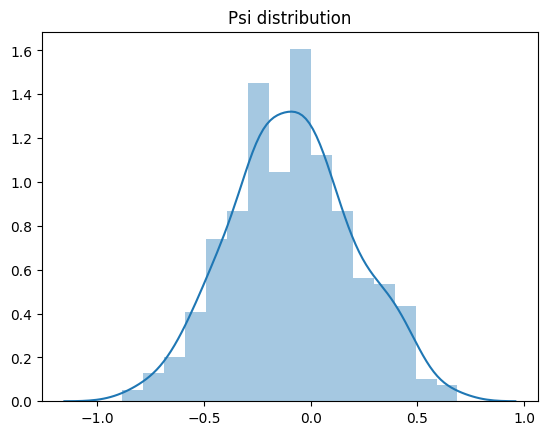

In [1216]:
psis = simulate(Smajor, Sminor, m, n, 0.5, True)
psi_bar = (1/B) * np.sum(psis)
print(f'Based on simulations we find an estimator psi_bar={psi_bar}')

In [1217]:
print(bootstrap_pencentile_ci(psis, alpha))

[-0.6347346200854335, 0.47511920562232207]


#### Section 3.4

In [1218]:
def prior_calc(data):
    pmajors = []
    pminors = []
    for _ in range(B):
        samples = data.sample(200, replace=True)
        tau = samples['key'].median()
        samples['Z'] = [1 if tau < x else 0 for x in samples['key']]
        # seperate between calsses
        minor = samples[samples['mode'] == 0]
        major = samples[samples['mode'] == 1]
        # calculate pj
        Pmajor = len(major[major['Z'] == 1]) / len(major)
        Pminor = len(minor[minor['Z'] == 1]) / len(minor)
        # add to corresponding lists
        pmajors.append(Pmajor)
        pminors.append(Pminor)
    return pmajors, pminors

In [1219]:
pmajors, pminors = prior_calc(priorData)

In [1220]:
def posterior_dist(pmajors, pminors):
    major_posterior = []
    minor_posterior = []
    for p1 in pmajors:
        major_posterior.append(np.log(np.divide(p1,1-p1)))
    for p2 in pminors:
        minor_posterior.append(np.log(np.divide(p2,1-p2)))
    sns.distplot(major_posterior, kde=True)  
    sns.distplot(minor_posterior, kde=True)
    plt.legend(labels=['major (p1)', 'minor (p2)'])
    plt.title('Posterior distributions')

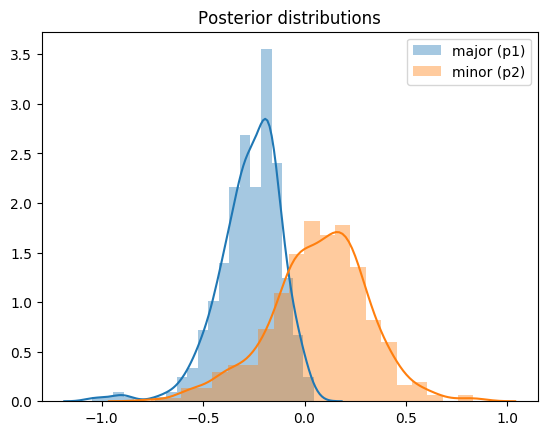

In [1221]:
posterior_dist(pmajors, pminors)

In [1222]:
major_alpha, major_beta, loc_major, scale_major = beta.fit(pmajors)
minor_alpha, minor_beta, loc_minor, scale_minor = beta.fit(pminors)

/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [1223]:
def simulations(alpha_major, beta_major, alpha_minor, beta_minor, hist=False):
    psis = []
    for _ in range(B):
        # sample pj from beta distribution
        Pmajor = np.random.beta(alpha_major, beta_major, 1)
        Pminor = np.random.beta(alpha_minor, beta_minor, 1)
        # calculate odds
        odds_pmajor = (Pmajor / (1 - Pmajor))
        odds_pminor = (Pminor / (1 - Pminor))
        # log of odds ratio
        psi = np.log(odds_pmajor) - np.log(odds_pminor)
        psis.append(psi)
    if hist:
        sns.distplot(psis, kde=True)  
        plt.title('Psi distribution')
    return psis

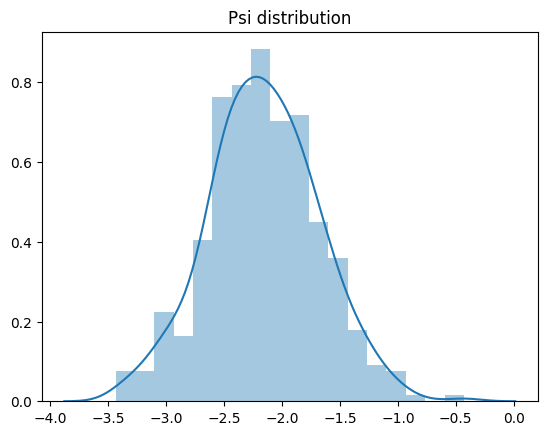

In [1224]:
psis = simulations(major_alpha, major_beta, minor_alpha, minor_beta, True)

In [1225]:
psi_bar = (1/B) * np.sum(psis)
print(f'Based on simulations we find an estimator psi_bar={psi_bar}')

Based on simulations we find an estimator psi_bar=-2.1592066507765804


In [1226]:
print(bootstrap_pencentile_ci(psis, alpha))

[-3.0978756001472547, -1.2585479949874945]


#### Section 3.5

As we can see the oods-ratio estimator is the smallest and it's very simillar to the uniformy & Jeffery's estimator.<br> We can say that this estimators are not subjective and the estimator that we got from our past data is bigger and more subjective.

## Part 2 - Missing Data

#### Section 1

In [1228]:
newSampledData = pd.concat([musicData, sampledData, priorData]).drop_duplicates(keep=False).sample(1000, random_state=1)

#### Section 2

In [1229]:
newSampledData.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target', 'Z'],
      dtype='object')

In [1230]:
newSampledData = newSampledData[['danceability','liveness','key','energy']]

$$ Y_{energy}=\beta_0 + \beta_1x_{danceability} + \beta_2x_{liveness} + \beta_3x_{key} $$

In [1231]:
matrix = newSampledData.to_numpy()
x = matrix[:,[0,1,2]]
x = np.append(np.ones((1000,1)), x, axis=1)
y = matrix[:, -1].copy()

In [1232]:
fullLinreg = sm.OLS(y,x).fit()
fullLinreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     25.41
Date:                Fri, 14 Aug 2020   Prob (F-statistic):           7.67e-16
Time:                        14:21:24   Log-Likelihood:                 48.883
No. Observations:                1000   AIC:                            -89.77
Df Residuals:                     996   BIC:                            -70.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5285      0.027     19.335      0.000       0.475       0.582
x1             0.1024      0.038      2.696      0.007       0.028       0.177
x2             0.3645      0.043      8.448      0.000       0.280       0.449
x3             0.0025      0.002      1.221      0.222      -0.001       0.006
==============================================================================
Omnibus:                       59.027   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.672
Skew:                          -0.639   Prob(JB):                     1.22e-15
Kurtosis:                       2.875   Cond. No.                         44.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1233]:
beta_cis = []
betas = []

In [1234]:
def beta_confidence_interval(i, x, beta, z_normal):
    C = np.linalg.inv(np.dot(x.T, x))
    left_limit = beta - z_normal * np.sqrt((fullLinreg.ssr/fullLinreg.df_resid) * C[i][i])
    right_limit = beta + z_normal * np.sqrt((fullLinreg.ssr/fullLinreg.df_resid) * C[i][i])
    return [left_limit.tolist(), right_limit.tolist()]

In [1235]:
regression_cis = []
for i, beta_hat in enumerate(fullLinreg.params):
    reg_ci = beta_confidence_interval(i, x, beta_hat, 1.96)
    regression_cis.append(reg_ci)
    print('confidence interval with 95% confidence for beta_{} is {}'.format(i, reg_ci))
betas.append(fullLinreg.params)

confidence interval with 95% confidence for beta_0 is [0.4749006485244466, 0.5820443578471827]
confidence interval with 95% confidence for beta_1 is [0.027966588379336035, 0.17688548171317808]
confidence interval with 95% confidence for beta_2 is [0.2799174751126757, 0.4490493167996172]
confidence interval with 95% confidence for beta_3 is [-0.0014864767986369786, 0.006403528550884694]


#### Section 3

In [1236]:
newSampledData = newSampledData.sort_values(by=['energy'])

In [1237]:
increment_by = (0.3)/500
bernoulli = []
for i in range(len(newSampledData)):
    p = 0.2 + increment_by * (i+1)
    bernoulli.append(1 if np.random.binomial(1, p+increment_by) else 0)

newSampledData['bernoulli_success'] = bernoulli

#### Section 4.1

In [1238]:
fullRemainingData = newSampledData[newSampledData.bernoulli_success != 1].drop(['bernoulli_success'], axis=1)

In [1239]:
fullRemainingData

,danceability,liveness,key,energy
4918,0.1690,0.1170,0,0.00183
667,0.2420,0.1290,7,0.00281
3904,0.1490,0.0746,9,0.00597
2797,0.0657,0.1350,11,0.00707
499,0.5820,0.1020,1,0.01030
...,...,...,...,...
2137,0.2660,0.3500,8,0.99600
5649,0.4060,0.0919,5,0.99600
3709,0.2070,0.1330,11,0.99700
5730,0.2510,0.3700,8,0.99800


In [1240]:
matrix = fullRemainingData.to_numpy()
x = matrix[:,[0,1,2]]
x = np.append(np.ones((len(fullRemainingData),1)), x, axis=1)
y = matrix[:, -1].copy()

In [1241]:
linreg = sm.OLS(y,x).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     20.65
Date:                Fri, 14 Aug 2020   Prob (F-statistic):           1.26e-12
Time:                        14:21:24   Log-Likelihood:                 9.9493
No. Observations:                 501   AIC:                            -11.90
Df Residuals:                     497   BIC:                             4.968
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3448      0.038      9.048      0.000       0.270       0.420
x1             0.2792      0.053      5.279      0.000       0.175       0.383
x2             0.4203      0.069      6.064      0.000       0.284       0.556
x3             0.0020      0.003      0.674      0.501      -0.004       0.008
==============================================================================
Omnibus:                       20.480   Durbin-Watson:                   0.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.792
Skew:                          -0.099   Prob(JB):                      0.00748
Kurtosis:                       2.344   Cond. No.                         45.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1242]:
halved_regression_cis = []
for i, beta_hat in enumerate(linreg.params):
    halved_reg_ci = beta_confidence_interval(i, x, beta_hat, 1.96)
    halved_regression_cis.append(halved_reg_ci)
    print('confidence interval with 95% confidence for beta_{} is {}'.format(i, halved_reg_ci))
beta_cis.append(halved_regression_cis)
betas.append(linreg.params)

confidence interval with 95% confidence for beta_0 is [0.27237052607712986, 0.4171877911484124]
confidence interval with 95% confidence for beta_1 is [0.17873142884816068, 0.37973887367382936]
confidence interval with 95% confidence for beta_2 is [0.2885693207996199, 0.5519480788492641]
confidence interval with 95% confidence for beta_3 is [-0.003552674240780782, 0.007455163580727593]


#### Section 4.2

In [1243]:
missingData = newSampledData[newSampledData.bernoulli_success != 0].drop(['bernoulli_success'], axis=1)

In [1244]:
missingData['energy'].values[:] = 0

In [1245]:
missingData.loc[missingData['energy'] == 0.0, 'energy'] = np.NAN

In [1246]:
halfEmptyData = pd.concat([fullRemainingData, missingData])

In [1247]:
halfEmptyData['R'] = [1 if not np.isnan(x) else 0 for x in halfEmptyData['energy']]

In [1248]:
halfEmptyData

,danceability,liveness,key,energy,R
4918,0.1690,0.1170,0,0.00183,1
667,0.2420,0.1290,7,0.00281,1
3904,0.1490,0.0746,9,0.00597,1
2797,0.0657,0.1350,11,0.00707,1
499,0.5820,0.1020,1,0.01030,1
...,...,...,...,...,...
2148,0.0802,0.3380,9,NaN,0
597,0.5210,0.6020,4,NaN,0
3460,0.4950,0.1840,8,NaN,0
4929,0.1790,0.9760,2,NaN,0


We assume $Y_i=\beta_0+\beta_1W_{{danceability}_i}+\beta_2W_{{liveness}_i}+\beta_3W_{{key}_i}$

In [1249]:
# estimating betas with beta estimation formula from lecture
def old_regression_imputation(data):
    first_sum = 0
    second_sum = 0
    for row in data.iterrows():
        Yi = row[1]['energy']
        Ri = row[1]['R']
        Ws = np.array([1, row[1]['danceability'],row[1]['liveness'],row[1]['key']]).reshape(1,-1)
        first_sum += Ri * np.matmul(Ws.transpose(), Ws)
        second_sum += Ri * Ws.transpose() * Yi if not np.isnan(Yi) else 0
    return np.dot(np.linalg.inv(first_sum), second_sum)

In [1250]:
# estimating betas with missing data filling and new regression
def regression_imputation(missingData, notMissingData, linreg, realMissingData):
    # missingData coverted to numpy array
    matrix = missingData.to_numpy()
    x = matrix[:,[0,1,2]]
    x = np.append(np.ones((len(missingData),1)), x, axis=1)
    # predicting the missing yi
    yis = linreg.predict(x)
    missingData['energy'] = yis
    # new filled data
    filledData = pd.concat([notMissingData, missingData])
    # convert data to x,y again
    matrix = filledData.to_numpy()
    x = matrix[:,[0,1,2]]
    x = np.append(np.ones((len(filledData),1)), x, axis=1)
    y = matrix[:, -1].copy()
    # estimate the new betas
    regression = sm.OLS(y,x).fit()
    #std = 1.96 * np.sqrt(mean_squared_error)
    
    sns.distplot(realMissingData['energy'], kde = False)
    sns.distplot(yis, kde = False)
    plt.legend(labels=['Real', 'Imputated'])
    plt.title('Differences between real and regression imputated Y')
    
    return regression.params, filledData

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


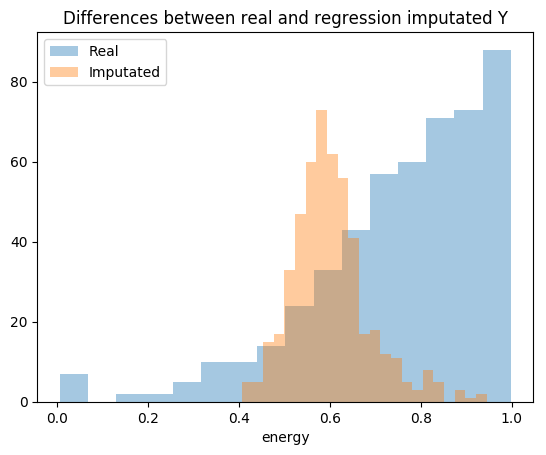

In [1251]:
reg_imp_params, filledData = regression_imputation(missingData, fullRemainingData, linreg, newSampledData[newSampledData.bernoulli_success != 0])
betas.append(reg_imp_params)

In [1252]:
print('The new dataset with filled data based on regression imputation:')
filledData

The new dataset with filled data based on regression imputation:


,danceability,liveness,key,energy
4918,0.1690,0.1170,0,0.001830
667,0.2420,0.1290,7,0.002810
3904,0.1490,0.0746,9,0.005970
2797,0.0657,0.1350,11,0.007070
499,0.5820,0.1020,1,0.010300
...,...,...,...,...
2148,0.0802,0.3380,9,0.526782
597,0.5210,0.6020,4,0.751061
3460,0.4950,0.1840,8,0.575938
4929,0.1790,0.9760,2,0.808837


In [1253]:
matrix = filledData.to_numpy()
x = matrix[:,[0,1,2]]
x = np.append(np.ones((len(filledData),1)), x, axis=1)

In [1254]:
regression_imputation_cis = []
for i, beta_hat in enumerate(reg_imp_params):
    reg_imp_ci = beta_confidence_interval(i, x, beta_hat, 1.96)
    regression_imputation_cis.append(reg_imp_ci)
    print(f'estimated beta{i}^={beta_hat} compared to beta{i}={linreg.params[i]}')
    print('confidence interval with 95% confidence for beta_{} using regression inputation is {}'.format(i, reg_imp_ci))
    print('#####################')
beta_cis.append(regression_imputation_cis)

estimated beta0^=0.34477915861277103 compared to beta0=0.34477915861277114
confidence interval with 95% confidence for beta_0 using regression inputation is [0.2912073039514029, 0.3983510132741392]
#####################
estimated beta1^=0.2792351512609952 compared to beta1=0.279235151260995
confidence interval with 95% confidence for beta_1 using regression inputation is [0.20477570459407413, 0.35369459792791624]
#####################
estimated beta2^=0.4202586998244425 compared to beta2=0.420258699824442
confidence interval with 95% confidence for beta_2 using regression inputation is [0.3356927789809717, 0.5048246206679133]
#####################
estimated beta3^=0.0019512446699734211 compared to beta3=0.0019512446699734055
confidence interval with 95% confidence for beta_3 using regression inputation is [-0.0019937580047874152, 0.005896247344734257]
#####################


It seems that using regression imputation we were able to estimate our model parameters almost perfectly, our estimation is really close to real parameters.

#### Section 4.3

In [1255]:
# We choose an M for this part
M = 5

In [1256]:
def draw_yi(data, betas, std):
    Yi_ms = []
    for row in data.iterrows():
        mean = betas[0] * 1 + betas[1] * row[1]['danceability'] + betas[2] * row[1]['liveness'] + betas[3] * row[1]['key']
        Yi_m = np.random.normal(mean, std, size=1)
        Yi_ms.append(Yi_m[0])
    return Yi_ms

In [1257]:
def multiple_imputation(missingData, notMissingData , betas, M, std):
    parameters = []
    Yis = []
    variances = []
    for _ in range(M):
        Yi_ms = draw_yi(missingData, betas, std)
        missingData['energy'] = Yi_ms
        filledData = pd.concat([notMissingData, missingData])
        # converting data to numpy arrays
        matrix = filledData.to_numpy()
        x = matrix[:,[0,1,2]]
        x = np.append(np.ones((len(filledData),1)), x, axis=1)
        y = matrix[:, -1].copy()
        linear_reg = sm.OLS(y,x).fit()
        parameters.append(linear_reg.params)
        Yis.append(Yi_ms)
        var = statsmodels.tools.eval_measures.mse(y, linear_reg.predict()) * np.linalg.inv(np.matmul(np.transpose(x),x))
        variances.append(var)
    return parameters, Yis, variances

In [1258]:
std = np.sqrt(statsmodels.tools.eval_measures.mse(np.array(fullRemainingData['energy']), linreg.predict()))
M_estimated_params, Yis, variances = multiple_imputation(missingData, fullRemainingData, linreg.params, M, std)

In [1259]:
estimated_params = (1/M) * np.sum(M_estimated_params, axis=0)
betas.append(estimated_params)

In [1260]:
estimated_var = (1/M) * np.sum(variances, axis=0)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Differences between real and multiple imputated Y')

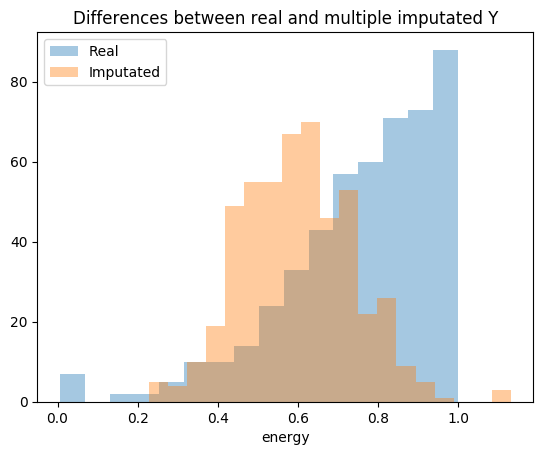

In [1261]:
sns.distplot(newSampledData[newSampledData.bernoulli_success != 0]['energy'], kde = False)
sns.distplot((1/M) * np.sum(Yis, axis=0), kde = False)
plt.legend(labels=['Real', 'Imputated'])
plt.title('Differences between real and multiple imputated Y')

In [1262]:
mult_imputation_cis = []
for i, beta_hat in enumerate(estimated_params):
    mult_imp_ci = beta_confidence_interval(i, x, beta_hat, 1.96)
    mult_imputation_cis.append(mult_imp_ci)
    print(f'estimated beta{i}^={beta_hat} compared to beta{i}={linreg.params[i]}')
    print('confidence interval with 95% confidence for beta_{} using multiple inputation is {}'.format(i, mult_imp_ci))
    print('#####################')
beta_cis.append(mult_imputation_cis)

estimated beta0^=0.33877485450170636 compared to beta0=0.34477915861277114
confidence interval with 95% confidence for beta_0 using multiple inputation is [0.2852029998403382, 0.3923467091630745]
#####################
estimated beta1^=0.285457671341174 compared to beta1=0.279235151260995
confidence interval with 95% confidence for beta_1 using multiple inputation is [0.21099822467425294, 0.35991711800809506]
#####################
estimated beta2^=0.42280999891340754 compared to beta2=0.420258699824442
confidence interval with 95% confidence for beta_2 using multiple inputation is [0.3382440780699367, 0.5073759197568783]
#####################
estimated beta3^=0.0021670011112877815 compared to beta3=0.0019512446699734055
confidence interval with 95% confidence for beta_3 using multiple inputation is [-0.0017780015634730546, 0.006112003786048618]
#####################


It seems that by using multiple imputation we were able to estimate our model parameters pretty close, however not as close as regression imputation.<br>
We assume that due to the fact that we draw uniform yi in this method in contrast of using real yi in regression imputation, this method is slightly less accurate.

#### Section 4.4

In [1263]:
betas_MI = M_estimated_params[-1]
betas.append(betas_MI)

In [1264]:
def robin_equation(M_est_params, MI_est, Yis, vars_est, M):
    std = 1.96 * np.sqrt(sum(vars_est)/M + (M+1) * (sum(np.power(M_est_params-MI_est,2))/(M * (M - 1))))
    MI_ci = []
    for i in range(len(MI_est)):
        MI_ci.append([MI_est[i] - std[i][i],MI_est[i] + std[i][i]])
    return MI_ci

In [1265]:
robin_cis = robin_equation(estimated_params, betas_MI, Yis, variances, M)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [1266]:
robin_ci = []
for i, ci in enumerate(robin_cis):
    robin_ci.append(ci)
    print('confidence interval with 95% confidence for beta_{}={} using multiple inputation is {}'.format(i, linreg.params[i], ci))
    print('#####################')
beta_cis.append(robin_ci)

confidence interval with 95% confidence for beta_0=0.34477915861277114 using multiple inputation is [0.26804844547566775, 0.4087844507065116]
#####################
confidence interval with 95% confidence for beta_1=0.279235151260995 using multiple inputation is [0.17979608247807763, 0.35635067372947116]
#####################
confidence interval with 95% confidence for beta_2=0.420258699824442 using multiple inputation is [0.36204479231660514, 0.5569848486662113]
#####################
confidence interval with 95% confidence for beta_3=0.0019512446699734055 using multiple inputation is [-0.042750666566572317, 0.04486373309142424]
#####################


#### Section 4.5

In [1268]:
matrix = halfEmptyData.to_numpy()
W = matrix[:,[0,1,2]]
W = np.append(np.ones((len(halfEmptyData),1)), W, axis=1)
R = matrix[:, -1].copy()

In [1269]:
logit = sm.Logit(R,W).fit()

Optimization terminated successfully.
         Current function value: 0.689545
         Iterations 4


In [1270]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Fri, 14 Aug 2020   Pseudo R-squ.:                0.005194
Time:                        14:21:26   Log-Likelihood:                -689.55
converged:                       True   LL-Null:                       -693.15
                                        LLR p-value:                   0.06580
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1096      0.238      0.461      0.645      -0.356       0.576
x1             0.1040      0.330      0.315      0.753      -0.544       0.752
x2            -0.9832      0.384     -2.558      0.011      -1.736      -0.230
x3             0.0065      0.018      0.369      0.712      -0.028       0.041
==============================================================================
"""

In [1271]:
pi_dist = []
params = logit.params
for row in halfEmptyData.iterrows():
    exponent = params[0] * 1 + params[1] * row[1]['danceability'] + params[2] * row[1]['liveness'] + params[3] * row[1]['key']
    PRx = np.divide(np.exp(exponent),1+np.exp(exponent))
    pi_dist.append(PRx)

#### Section 4.6

In [1272]:
def s(x, data, pi):
    data.fillna(0)
    score = 0
    for i, row in enumerate(data.iterrows()):
        if row[1]['R']:
            score += (row[1]['R']/pi[i]) * (row[1]['energy'] - (x[0] * 1 + x[1] * row[1]['danceability'] + x[2] * row[1]['liveness'] + x[3] * row[1]['key']))**2
    return score

In [1273]:
minimum = fmin(s,np.array([0,0,0,0]),args=(halfEmptyData, pi_dist))

Optimization terminated successfully.
         Current function value: 56.377478
         Iterations: 357
         Function evaluations: 608


In [1274]:
betas.append(minimum)

#### Section 4.7

In [1275]:
bootstrap_betas = []
for b in range(B):
    x = []
    y = []
    samples = halfEmptyData.sample(len(halfEmptyData), replace=True, random_state=b)
    X_b = samples[['danceability','liveness','key']]
    Y_b = samples['R']
    logit_b = sm.Logit(Y_b, X_b).fit(disp=False)
    params_b = logit_b.params.to_numpy()
    for index, row in samples.iterrows():
        if row['R']:
            r = [1, row['danceability'],row['liveness'],row['key']]
            proba = logit_b.predict(params_b, r)
            pi_w = np.sqrt(proba)
            r = r[1:]/pi_w
            r = np.insert(r,0,1)
            x.append(r)
            y.append(row['energy']/pi_w)
    x = np.array(x)
    y = np.array(y)
    beta_b = (np.linalg.inv((x.T).dot(x)).dot(x.T)).dot(y)
    bootstrap_betas.append(beta_b)

In [1276]:
beta_index = []
for i in range(4):
    beta = []
    for b in bootstrap_betas:
        beta.append(b[i])
    beta_index.append(beta)

In [1277]:
ipws_ci = []
for i, beta_hats in enumerate(beta_index):
    ipw_ci = bootstrap_pencentile_ci(beta_hats, alpha)
    ipws_ci.append(ipw_ci)
    print(f'estimated beta{i}^={beta_hat} compared to beta{i}={linreg.params[i]}')
    print('confidence interval with 95% confidence for beta_{} using multiple inputation is {}'.format(i, ipw_ci))
    print('#####################')
beta_cis.append(ipws_ci)

estimated beta0^=0.0021670011112877815 compared to beta0=0.34477915861277114
confidence interval with 95% confidence for beta_0 using multiple inputation is [0.3057660322186528, 0.5338679330989954]
#####################
estimated beta1^=0.0021670011112877815 compared to beta1=0.279235151260995
confidence interval with 95% confidence for beta_1 using multiple inputation is [0.1575364933638898, 0.390769032125551]
#####################
estimated beta2^=0.0021670011112877815 compared to beta2=0.420258699824442
confidence interval with 95% confidence for beta_2 using multiple inputation is [0.29920675960514187, 0.565215832162517]
#####################
estimated beta3^=0.0021670011112877815 compared to beta3=0.0019512446699734055
confidence interval with 95% confidence for beta_3 using multiple inputation is [-0.003577698454707654, 0.007627984505854562]
#####################


#### Section 4.8.1

In [1278]:
beta_indexes = []
for i in range(4):
    beta2 = []
    for b in betas:
        beta2.append(b[i])
    beta_indexes.append(beta2)

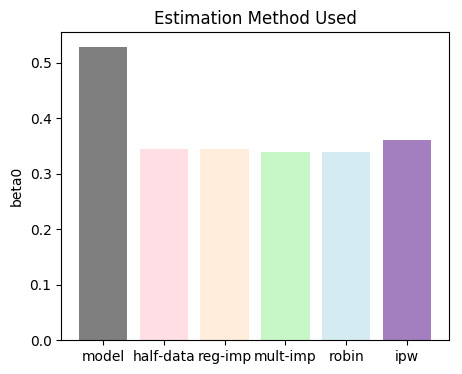

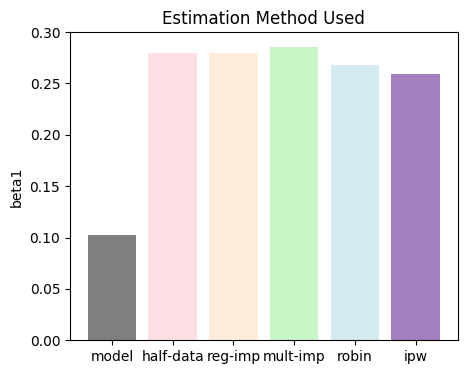

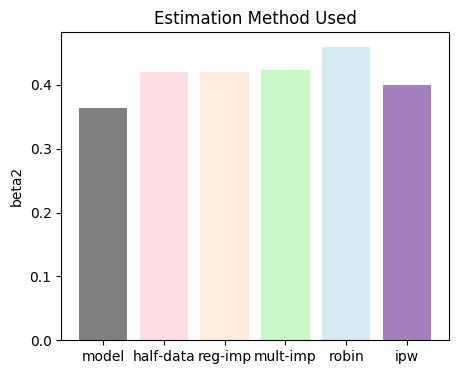

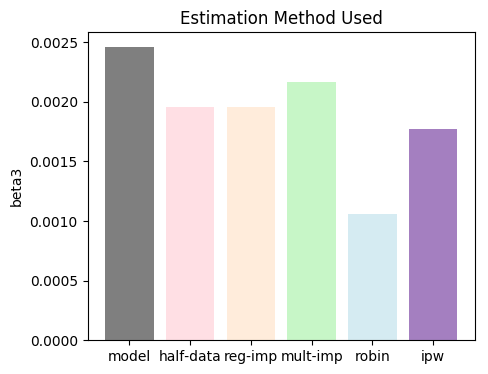

In [1279]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

colors = ['black','pink', 'peachpuff', 'lightgreen','lightblue','indigo']
objects = ('model','half-data', 'reg-imp', 'mult-imp', 'robin','ipw')
for i in range(4):
    plt.figure(figsize=(5,4))
    y_pos = np.arange(len(objects))
    performance = beta_indexes[i]

    plt.bar(y_pos, performance, align='center', alpha=0.5, color=colors)
    plt.xticks(y_pos, objects)
    plt.ylabel(f'beta{i}')
    plt.title('Estimation Method Used')

    plt.show()

It seems most methods doesnt really succeed in estimating the betas 0 and 1 of the real model (gray) with an exception of beta2 and beta3 which is the liveness and key.<br>
They do however succeed well in estimating the parameters of our half full model (pink) presented in section 4.3. <br>
Beta2 seems to be the most informative variable in our model since it gets the highest weight of all variables and so it seems that for this reason all methods seem to better succeed estimating this parameter.

#### Section 4.8.2

In [1280]:
def ci_boxplot(intervals):
    labels = ['only-full-data', 'reg-imp', 'mult-imp', 'robin','ipw']
    for index, beta in enumerate(fullLinreg.params):
        ci_intervals = [interval[index] for interval in intervals]
        plt.figure(figsize=(5,4))
        # plot box plots of each sample mean.
        bplot = plt.boxplot(ci_intervals,
                   vert=True,
                   patch_artist=True,
                   labels=labels)
        colors = ['pink', 'peachpuff', 'lightgreen','lightblue','indigo']
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        plt.title(f'CIs of beta{index}')
        plt.plot([1, len(ci_intervals)],[beta,beta], 'k-', lw=1, color='red')
        plt.show()

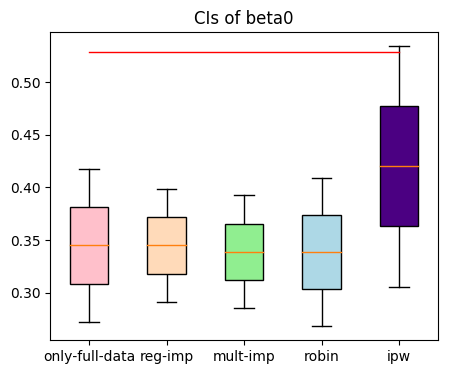

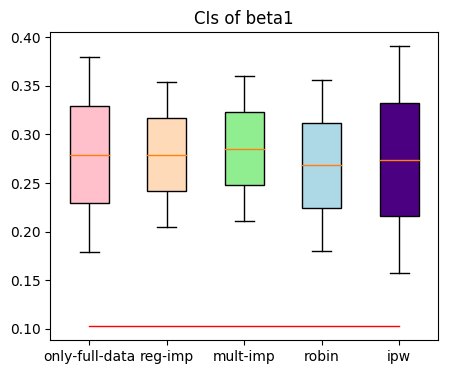

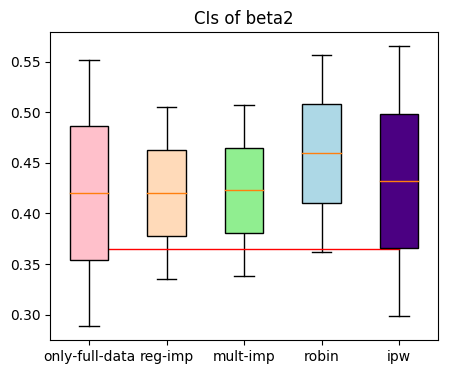

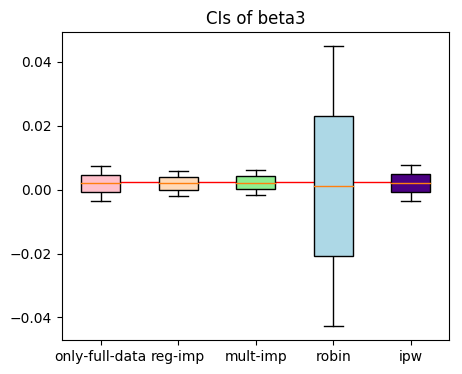

In [1281]:
ci_boxplot(beta_cis)

First, we can see that no interval of our methods captured beta0 and beta1 which are the intercept and the danceability parameters.<br>
All intervals captured beta2 and beta3 which are the liveness and key parameters.<br>
We saw on the last section that our methods did capture quite well the half full data we had from section 3, but do worse on the full model from section 2.<br>
For this reason our intervals also do worse on the full model.